# Main program for P3

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import shutil
import os
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
def gen_time_encoding(t: float, d: int = 20):
    ''' Generate a time embedding vector with sin/cos function. dim d.'''
    parts = []
    for k in range(d//2):
        w = 1 / 10000 ** (2*k/d)
        parts.append( [np.sin(w * t), np.cos(w * t)] )
    ans = np.concatenate(parts)
    return ans


# create dataset
class WordDataset(Dataset):
    def __init__(self):
        data = pd.read_excel('../datafeatures_14_0220a.xlsx')
        # print(data.head())
        self.date = data['Date']
        self.START_DAY = pd.Timestamp(self.date[0])
        data = data.to_numpy()
        self.data = data[:, 15:].astype(np.float64)
        self.words = data[:, 3]
        # n = len(self.data)
        ## data processing ##
        # last 8 column normalization
        # self.data[:, -9: -1] = (self.data[:, -9: -1] - self.data[:, -9: -1].mean(axis=0)) / \
        #     self.data[:, -9: -1].std(axis=0)

        self.targets = torch.FloatTensor(data[:, 6:13].astype(np.float64))
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        ''' Return sample(R^14), target R^7 '''
        word = self.words[index]
        sample = torch.concat([
            self.data[index], 
            torch.FloatTensor(
                gen_time_encoding( (self.date[index]  - self.START_DAY) / pd.Timedelta('1 day') )
            )
        ])
        target = self.targets[index]
        return [word, str(self.date[index])], sample, target / torch.sum(target)

def extract_from_dataloader(loader: DataLoader):
    ''' Extracted data from target'''
    data = []
    gt = []
    for meta, sample, target in loader:
        data.append(sample.numpy())
        gt.append(target.numpy())
    data = np.concatenate(data)
    gt = np.concatenate(gt)
    print('extracting dataloader:', data.shape, gt.shape)
    return data, gt

In [3]:
dataset = WordDataset()

train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 8
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
train_loader_ordered = DataLoader(train_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
print(dataset[10])
print(dataset[10][1].shape)
X_train, y_train = extract_from_dataloader(train_loader_ordered)
X_test, y_test = extract_from_dataloader(test_loader)

(['shire', '2022-01-17 00:00:00'], tensor([ 0.0254,  0.8886, -0.1504,  1.4325,  2.3979,  2.0684, -0.6606,  0.9567,
         0.9546, -0.4155,  0.3637, -0.4011,  0.0356,  0.0506, -0.5440, -0.8391,
        -0.7443, -0.6679,  0.9999, -0.0141,  0.5899,  0.8075,  0.2486,  0.9686,
         0.0998,  0.9950,  0.0398,  0.9992,  0.0158,  0.9999,  0.0063,  1.0000,
         0.0025,  1.0000]), tensor([0.0099, 0.0792, 0.3168, 0.3168, 0.1782, 0.0792, 0.0198]))
torch.Size([34])
extracting dataloader: (323, 34) (323, 7)
extracting dataloader: (36, 34) (36, 7)


In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(34, 48), nn.BatchNorm1d(48), nn.Dropout(0.5), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(48, 48), nn.BatchNorm1d(48), nn.Dropout(0.5), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(48, 7), nn.ReLU())
        self.softmax = nn.Softmax(1)
    
    def forward(self,x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        return self.softmax(x3)

## Train NN

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MLP().to(device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 500

tbar = tqdm(range(num_epochs))

best_so_far = float('inf')
best_epoch = -1

loss_weight = torch.FloatTensor([3, 2, 1, 1, 1, 2, 3])
loss_weight = torch.ones(7)
def element_weighted_loss(y_hat, y):
    loss = criterion(y_hat, y)
    loss = loss * loss_weight
    return torch.sum(loss.sum(axis=1) / loss_weight.sum())

model.train()
for e in tbar:
    batch_loss = []
    for _, sample, target in train_loader:
        sample, target = sample.to(device), target.to(device)
        out = model(sample)
        loss = element_weighted_loss(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        batch_loss.append(loss.cpu().item())
    
    epoch_loss = sum(batch_loss)/len(batch_loss)
    tbar.set_postfix(loss=epoch_loss)

    if epoch_loss < best_so_far:
        best_so_far = epoch_loss
        best_epoch = e
        torch.save(model.state_dict(), 'best.pth')

    if e - best_epoch > 100:
        print('early stop!')
        break

torch.save(model.state_dict(), 'model.pth')
print(f'Finished with best loss: {best_so_far}')

100%|██████████| 500/500 [01:20<00:00,  6.18it/s, loss=0.216]

Finished with best loss: 0.20152096341295941


## evaluate on NN

optional: export the img as well

In [6]:
EXPORT_IMG = False
if EXPORT_IMG:
    shutil.rmtree('./test/')
    os.mkdir('./test') 

model.load_state_dict(torch.load('best.pth'))
model.eval()
total_loss = []
predicted = []
metadata = []
criterion_eval = nn.L1Loss()
for meta, sample, target in test_loader:
    sample, target = sample.to(device), target.to(device)
    out = model(sample)
    loss = criterion_eval(out, target)  
    total_loss.append(loss.cpu().item())
    predicted.append(out.cpu().detach().numpy())
    metadata.append(meta)
    if EXPORT_IMG:
        for i in range(len(out)):
            plt.plot(np.arange(7), out[i].detach().numpy().reshape(-1), np.arange(7), target[i].numpy().reshape(-1))
            plt.legend(['predicted', 'gt'])
            plt.savefig(f'test/{i}_`{meta[0][i]}, {meta[1][i][:10]}`.png')
            plt.close()
predicted = np.concatenate(predicted)

print(np.array(total_loss).mean())

0.03176847476667414


In [7]:
# gen all NN's train prediction
model.eval()

X_NN_output = []
for meta, sample, target in train_loader_ordered:
    sample, target = sample.to(device), target.to(device)
    out = model(sample)

    X_NN_output.append(out.cpu().detach().numpy())

X_NN_output = np.concatenate(X_NN_output)
X_NN_output.shape

(323, 7)

## Train RF

In [8]:
from sklearn.ensemble import RandomForestRegressor

forward_indices = [2,4,6,7,12,13]
middle_indices = list(range(14))#[1,2,3,7,12,13]
backward_indices = [1,2,6,7,12,13]

model_f = RandomForestRegressor(n_estimators=200, min_samples_leaf=3)
model_f = model_f.fit(X_train[:, forward_indices], y_train[:, 0:3])

model_m = RandomForestRegressor(n_estimators=200, min_samples_leaf=3)
model_m = model_m.fit(X_train[:, middle_indices], y_train[:, 2:5])

model_b = RandomForestRegressor(n_estimators=200, min_samples_leaf=3)
model_b = model_b.fit(X_train[:, backward_indices], y_train[:, 4:])

model_all = RandomForestRegressor(n_estimators=200, min_samples_leaf=3)
model_all = model_all.fit(X_train, y_train)


## evaluate on RF

In [25]:
print( np.abs(model_f.predict(X_test[:, forward_indices]) - y_test[:, 0:3]).mean() )
print( np.abs(model_m.predict(X_test[:, middle_indices]) - y_test[:, 2:5]).mean() )
print( np.abs(model_b.predict(X_test[:, backward_indices]) - y_test[:, 4:]).mean() )
print( np.abs(model_all.predict(X_test) - y_test).mean() )


0.02849843613506946
0.04212662980900607
0.034243181992368546
0.03217949896047609


In [10]:
# get RF's prediction
X_RF_f_output = model_f.predict(X_train[:, forward_indices])
X_RF_m_output = model_m.predict(X_train[:, middle_indices])
X_RF_b_output = model_b.predict(X_train[:, backward_indices])
X_RF_b_output.shape, X_RF_f_output.shape, X_RF_m_output.shape

((323, 3), (323, 3), (323, 3))

In [11]:
shutil.rmtree('./vis_diff/')
os.mkdir('./vis_diff') 
for i in range(len(X_train)):
    plt.plot(np.arange(7), X_NN_output[i, :].squeeze(), np.arange(7), y_train[i, :].squeeze(), np.arange(3), X_RF_f_output[i, :].squeeze(), 
        np.arange(2, 5), X_RF_m_output[i, :].squeeze(),np.arange(4, 7), X_RF_b_output[i, :].squeeze(), )
    plt.legend(['NN', 'gt', 'RF-f', 'RF-m', 'RF-b'])
    plt.savefig(f'vis_diff/{i}.png')
    plt.close()

In [12]:
# plot a: good fit both
INDEX = 191
import scienceplots
plt.style.use('ieee')

plt.plot(np.arange(7), X_NN_output[i, :].squeeze(), np.arange(7), y_train[i, :].squeeze(), np.arange(3), X_RF_f_output[i, :].squeeze(), 
    np.arange(2, 5), X_RF_m_output[i, :].squeeze(),np.arange(4, 7), X_RF_b_output[i, :].squeeze(), )
plt.legend(['NN', 'gt', 'RF-f', 'RF-m', 'RF-b'])
plt.savefig(f'vis_good_all.png')
plt.close()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


In [13]:
# plot 

## dim-wise evaluate

In [24]:
print( np.abs(model_all.predict(X_test) - y_test).mean(axis=0) )
print( np.abs(predicted - y_test).mean(axis=0))

[0.00388921 0.02402182 0.0575624  0.03345352 0.0396921  0.04769444
 0.01894302]
[0.00371928 0.02204184 0.05604887 0.03370999 0.0388566  0.04857236
 0.01943037]


## Joint Linear Regression

In [15]:
np.vstack((
    X_NN_output[:, 0],
    X_RF_f_output[:, 0],
)).T

array([[0.00705611, 0.00654071],
       [0.01212754, 0.00695279],
       [0.00459126, 0.00095281],
       [0.00324748, 0.00361804],
       [0.00523417, 0.00287154],
       [0.00653616, 0.00160653],
       [0.00510582, 0.003608  ],
       [0.00249225, 0.00162925],
       [0.00405887, 0.00787012],
       [0.0037309 , 0.00301149],
       [0.01559417, 0.00544084],
       [0.00253892, 0.00197901],
       [0.0029369 , 0.00174552],
       [0.00311724, 0.00294873],
       [0.00553217, 0.00537322],
       [0.00380808, 0.0041255 ],
       [0.00176569, 0.00165551],
       [0.0042662 , 0.00386038],
       [0.00637399, 0.00523747],
       [0.00453916, 0.00283477],
       [0.00255989, 0.00157622],
       [0.00619978, 0.00585831],
       [0.0036385 , 0.00370891],
       [0.00631339, 0.00267335],
       [0.00409769, 0.00091773],
       [0.00208914, 0.00227283],
       [0.01010778, 0.00449024],
       [0.00361658, 0.00068542],
       [0.00430611, 0.0023756 ],
       [0.00819198, 0.00848682],
       [0.

In [16]:
from sklearn.linear_model import LinearRegression, Lasso
alpha = 0.001
o1 = LinearRegression().fit(
    np.vstack((X_NN_output[:, 0], X_RF_f_output[:, 0],)).T, 
    y_train[:, 0]
)
o2 = LinearRegression().fit(
    np.vstack((X_NN_output[:, 1], X_RF_f_output[:, 1],)).T, 
    y_train[:, 1]
)
o3 = Lasso(alpha=alpha).fit(
    np.vstack((X_NN_output[:, 2], X_RF_f_output[:, 2], X_RF_m_output[:, 0],)).T, 
    y_train[:, 2]
)
o4 = Lasso(alpha=alpha).fit(
    np.vstack((X_NN_output[:, 3], X_RF_m_output[:, 1],)).T, 
    y_train[:, 2]
)
o5 = Lasso(alpha=alpha).fit(
    np.vstack((X_NN_output[:, 4], X_RF_m_output[:, 2], X_RF_b_output[:, 0], )).T, 
    y_train[:, 2]
)
o6 = LinearRegression().fit(
    np.vstack((X_NN_output[:, 5], X_RF_b_output[:, 1],)).T, 
    y_train[:, 2]
)
o7 = LinearRegression().fit(
    np.vstack((X_NN_output[:, 6], X_RF_b_output[:, 2],)).T, 
    y_train[:, 2]
)

In [17]:
o7.coef_

array([-4.28049395, -1.0450043 ])

In [18]:
o2.predict(np.vstack((
        predicted[:, 2],
        model_f.predict(X_test[:, forward_indices])[:, 2],
    )).T, )

array([0.33541001, 0.23089792, 0.21939995, 0.42288166, 0.32003267,
       0.1620182 , 0.23977277, 0.38702462, 0.37612587, 0.28567379,
       0.3672184 , 0.27187671, 0.30915781, 0.26759089, 0.20587645,
       0.32080208, 0.30731592, 0.32600392, 0.32065015, 0.23976819,
       0.42272308, 0.35441419, 0.40600817, 0.28657277, 0.27731448,
       0.23832943, 0.3254433 , 0.26650837, 0.37941637, 0.23318437,
       0.25352366, 0.38258319, 0.17792513, 0.29116896, 0.34893192,
       0.26629887])

## Final: inference

In [19]:
import feature_utils as futils
import pickle

with open('../stats2309_14.pkl', 'rb') as f:
    stats = pickle.load(f)

def get_commonality(word):
    ''' '''
    df = pd.read_csv('../freq_5letters_possiblewords.csv')
    if word in df['word']:
        return float(df.loc[ df['word'] == word ]['freq'])
    else:
        return -2.

def make_feature_vector(word: str, date: str):
    ''' Make 14+20 dim feature vector'''
    with open('double_counts_2309.pkl', 'rb') as f:
        double_counts = pickle.load(f)
    with open('trible_counts_2309.pkl', 'rb') as f:
        trible_counts = pickle.load(f)
    with open('end_counts_2309.pkl', 'rb') as f:
        end_counts = pickle.load(f)
    with open('spaced_double_counts_2309.pkl', 'rb') as f:
        spaced_double_counts = pickle.load(f)
    with open('freq_counts_2309.pkl', 'rb') as f:
        freq_counts = pickle.load(f)
    with open('begin_counts_2309.pkl', 'rb') as f:
        begin_counts = pickle.load(f)
    array = [
        # 0.10, 
        futils.get_double_score(word, double_counts),
        futils.get_trible_score(word, trible_counts),
        futils.get_end_score(word, end_counts), 
        futils.get_spaced_double_score(word, spaced_double_counts),
        futils.get_begin_score(word, begin_counts), 
        futils.get_duplicate_score(word), 
        futils.get_freq_score(word, freq_counts),
        futils.get_freq_score_weighted(word, freq_counts),
        futils.get_duplicate_conti_score(word), 
        futils.get_vowel_number_score(word), 
        futils.get_begin_vowel_score(word), 
        get_commonality(word), 
        futils.get_freq_var_score(word, freq_counts)
    ]
    array = (np.array(array) - np.array(stats[0])) / np.array(stats[1])
    # print(array)
    START_DAY = pd.Timestamp('2022-1-7')
    t = (pd.Timestamp(date) - START_DAY) / pd.Timedelta('1 day')
    # print(t)
    # print(gen_time_encoding(t))
    return torch.FloatTensor( np.concatenate( [np.array([0.1]), array, gen_time_encoding(t)] ) )
    

vec = make_feature_vector('eerie', '2023-3-1')

vec = vec.reshape(1, -1)
result_NN = model(vec).detach().numpy()

In [20]:
result_RF = model_all.predict(vec.numpy())
result_RF_f = model_f.predict(vec.numpy()[:, forward_indices])
result_RF_m = model_m.predict(vec.numpy()[:, middle_indices])
result_RF_b = model_b.predict(vec.numpy()[:, backward_indices])

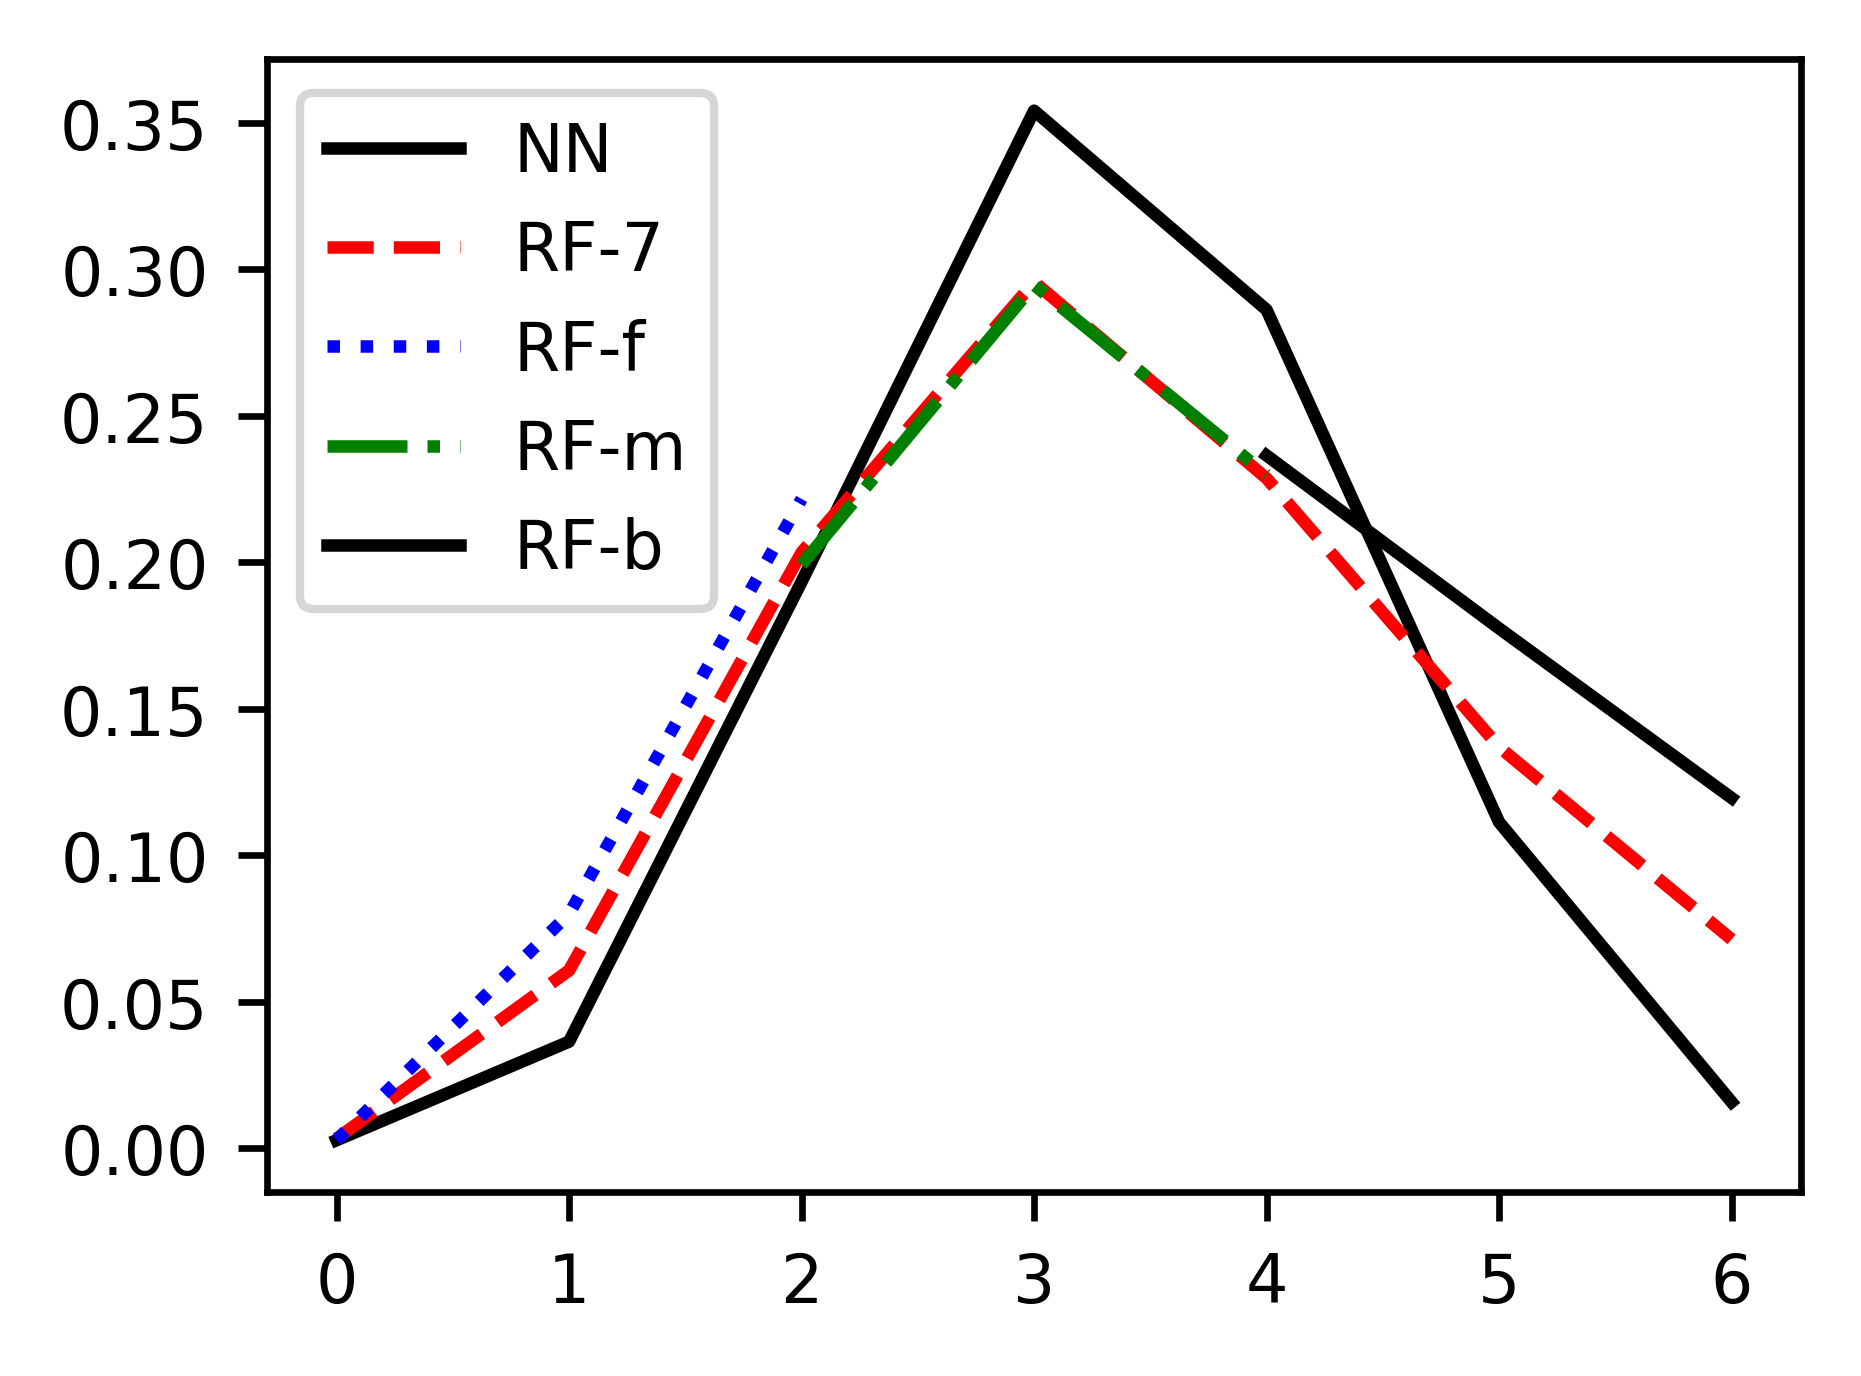

In [21]:
plt.plot(np.arange(7), result_NN.squeeze(), np.arange(7), result_RF.squeeze(), np.arange(3), result_RF_f.squeeze(), 
    np.arange(2, 5), result_RF_m.squeeze(),np.arange(4, 7), result_RF_b.squeeze(), )
plt.legend(['NN', 'RF-7', 'RF-f', 'RF-m', 'RF-b'])

In [22]:
result_NN
result_RF_b

array([[0.2364445 , 0.1774416 , 0.11957563]])

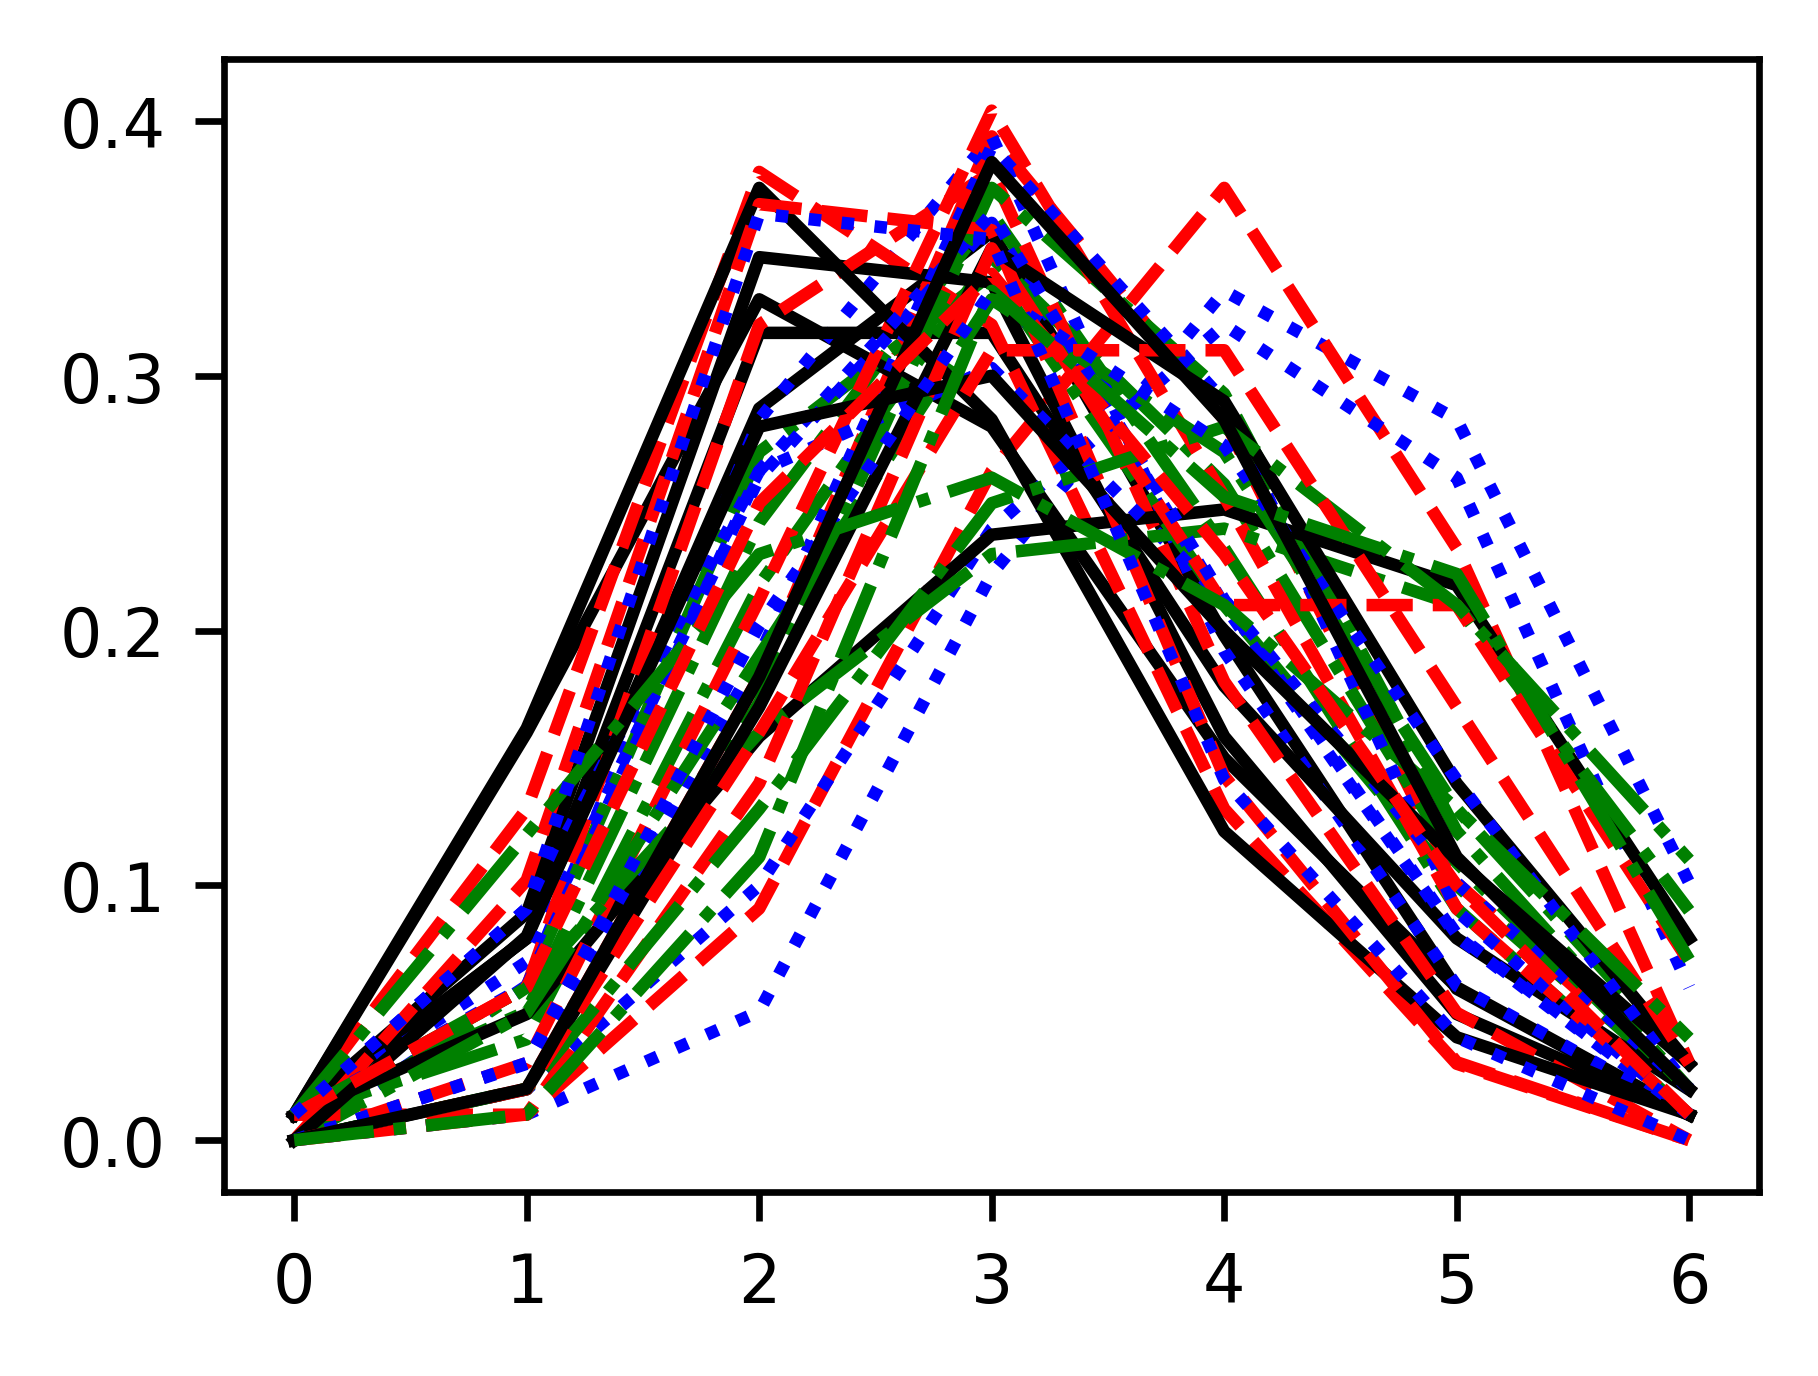

In [23]:
for i in range(len(y_test)):
    plt.plot(y_test[i, :])